In [2]:
from pathlib import Path
from warnings import filterwarnings
import time
import sqlite3

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator
import sqlite3
import csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results

/var/folders/02/fvfmdq_j709g1tthj47t5fcm0000gn/T/ipykernel_72258/424582492.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Prepare for the data
conn = sqlite3.connect('database.db')
# Create a cursor object
cursor = conn.cursor()

# SQL query to select data
query = "SELECT * FROM assays INNER JOIN compounds ON assays.cid = compounds.cid;"  # Replace with your query
cursor.execute(query)
data = cursor.fetchall()
cid = [x[0] for x in data]
f_avg_IC50 = [x[1] for x in data]
r_avg_IC50 = [x[2] for x in data]
avg_IC50 = [x[3] for x in data]
avg_pIC50 = [x[4] for x in data]
smiles = [x[6] for x in data]
hbd = [x[7] for x in data]
hba = [x[8] for x in data]
c_logp = [x[9] for x in data]
mw = [x[10] for x in data]

df = pd.DataFrame({
    'cid': cid,
    'f_avg_IC50': f_avg_IC50,
    'r_avg_IC50': r_avg_IC50,
    'avg_IC50': avg_IC50,
    'avg_pIC50': avg_pIC50,
    'smiles': smiles,
    'hbd': hbd,
    'hba': hba,
    'c_logp': c_logp,
    'mw': mw,})

conn.close()

df.head()

,cid,f_avg_IC50,r_avg_IC50,avg_IC50,avg_pIC50,smiles,hbd,hba,c_logp,mw
0,DAR-DIA-23aa0b97-19,26.719515,14.641091,20.680303,4.684443,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,1,4,3.28768,287.322
1,DAR-DIA-23aa0b97-20,57.590417,45.077469,51.333943,4.289595,O=C(Cc1cncc2ccccc12)Nc1ccccc1,1,3,3.41600,262.312
2,TRY-UNI-714a760b-3,4.222340,8.201698,6.212019,5.206767,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,3,4,2.80682,275.739
3,TRY-UNI-714a760b-6,24.581194,13.895165,19.238180,4.715836,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,1,3,3.22462,260.724
4,TRY-UNI-714a760b-12,64.508813,45.689263,55.099038,4.258856,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,2,4,3.68742,261.712


In [5]:
print("Shape of dataframe : ", df.shape)
df.head()

Shape of dataframe :  (662, 10)


,cid,f_avg_IC50,r_avg_IC50,avg_IC50,avg_pIC50,smiles,hbd,hba,c_logp,mw
0,DAR-DIA-23aa0b97-19,26.719515,14.641091,20.680303,4.684443,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,1,4,3.28768,287.322
1,DAR-DIA-23aa0b97-20,57.590417,45.077469,51.333943,4.289595,O=C(Cc1cncc2ccccc12)Nc1ccccc1,1,3,3.41600,262.312
2,TRY-UNI-714a760b-3,4.222340,8.201698,6.212019,5.206767,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,3,4,2.80682,275.739
3,TRY-UNI-714a760b-6,24.581194,13.895165,19.238180,4.715836,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,1,3,3.22462,260.724
4,TRY-UNI-714a760b-12,64.508813,45.689263,55.099038,4.258856,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,2,4,3.68742,261.712


In [8]:
# Keep only the columns we want
df = df[["cid", "smiles", "avg_pIC50"]]
df.head()
# NBVAL_CHECK_OUTPUT
print(np.median(avg_pIC50)) ##cutoff



4.721139348057899


In [10]:
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
df.loc[df[df.avg_pIC50 >= 4.72].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(df.active.sum()))
print("Number of inactive compounds:", len(df) - int(df.active.sum()))

df.head()


Number of active compounds: 332
Number of inactive compounds: 330


,cid,smiles,avg_pIC50,active
0,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,4.684443,0.0
1,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,4.289595,0.0
2,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,5.206767,1.0
3,TRY-UNI-714a760b-6,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,4.715836,0.0
4,TRY-UNI-714a760b-12,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,4.258856,0.0


In [11]:
def smiles_to_fp(smiles, method="morgan2", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [12]:
compound_df = df.copy()


In [45]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,cid,smiles,avg_pIC50,active,fp
0,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,4.684443,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,4.289595,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,5.206767,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [46]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [47]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [48]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [49]:
from sklearn.metrics import f1_score


fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


Training data size: 529
Test data size: 133


In [50]:
# Set model parameter for random forest
from sklearn.ensemble import RandomForestClassifier
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [53]:
def f1_score_calc(ml_model, name, splits, verbose=True):
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)
    return ml_model.predict(test_x)

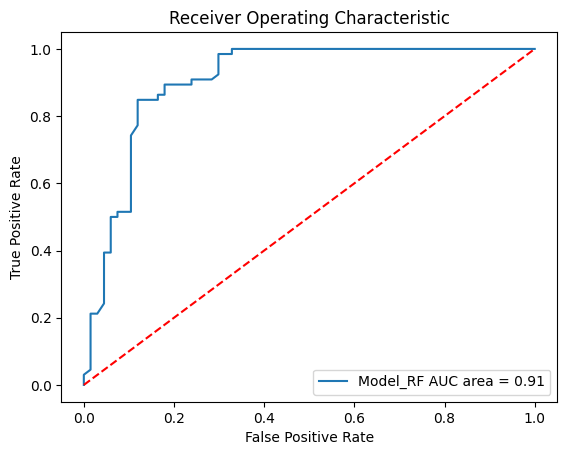

In [23]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
figure = plot_roc_curves_for_models(models, static_test_x, static_test_y)

In [24]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.79
Specificity: 0.85
AUC: 0.88


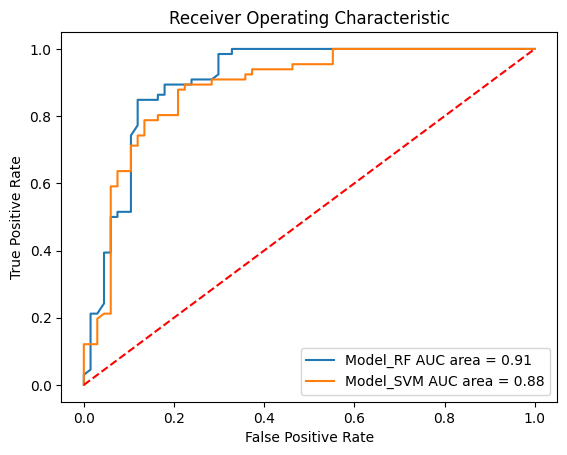

In [25]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [28]:
# Specify model
from sklearn.neural_network import MLPClassifier


model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3))

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.80
Specificity: 0.73
AUC: 0.88


NameError: name 'DATA' is not defined

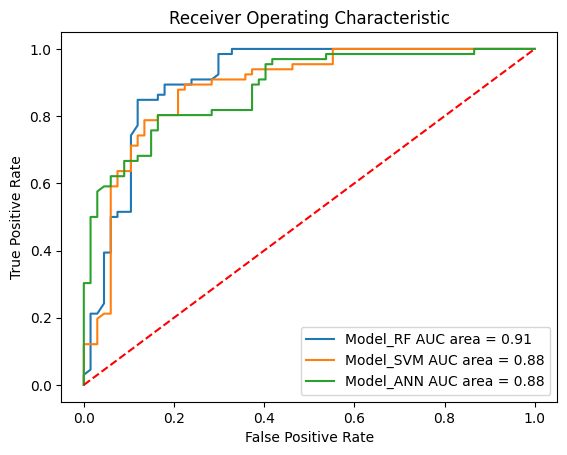

In [29]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

In [33]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [34]:
N_FOLDS = 5

In [35]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.85 	and std : 0.02 
Mean sensitivity: 0.85 	and std : 0.04 
Mean specificity: 0.84 	and std : 0.03 
Mean AUC: 0.91 	and std : 0.01 
Time taken : 0.66s


Model_SVM
Mean accuracy: 0.84 	and std : 0.05 
Mean sensitivity: 0.80 	and std : 0.07 
Mean specificity: 0.90 	and std : 0.06 
Mean AUC: 0.91 	and std : 0.04 
Time taken : 6.85s


Model_ANN
Mean accuracy: 0.83 	and std : 0.02 
Mean sensitivity: 0.82 	and std : 0.12 
Mean specificity: 0.84 	and std : 0.08 
Mean AUC: 0.91 	and std : 0.02 
Time taken : 4.23s



In [57]:
# Fit model on single split
performance_measures = f1_score_calc(model_RF, "RF", splits)

f1 = f1_score(static_test_y, performance_measures, average='binary')
print(f1)

0.816


In [61]:
# Fit model on single split
performance_measures_RF = f1_score_calc(model_RF, "RF", splits)
performance_measures_svm = f1_score_calc(model_SVM, "SVM", splits)


f1_RF = f1_score(static_test_y, performance_measures_RF, average='binary')
print("RF F1 SCORE IS", f1_RF)
f1_SVM = f1_score(static_test_y, performance_measures_svm, average='binary')
print("SVM F1 SCORE IS", f1_SVM)

## you can bootstrap for reliability? 

RF F1 SCORE IS 0.7804878048780488
SVM F1 SCORE IS 0.819672131147541


In [66]:
from sklearn.metrics import confusion_matrix

CM_RF = confusion_matrix(static_test_y, performance_measures_RF)
print("RF CM IS\n", CM_RF)
CM_SVM = confusion_matrix(static_test_y, performance_measures_svm)
print("SVM CM IS\n", CM_SVM)

# Top-Left (True Positive, TP): The number of instances correctly predicted as positive.
# Top-Right (False Positive, FP): The number of instances incorrectly predicted as positive when they are actually negative.
# Bottom-Left (False Negative, FN): The number of instances incorrectly predicted as negative when they are actually positive.
# Bottom-Right (True Negative, TN): The number of instances correctly predicted as negative."""

RF CM IS
 [[59 10]
 [13 51]]
SVM CM IS
 [[61  8]
 [14 50]]


In [ ]:
from sklearn.metrics import matthews_corrcoef

MCC_RF = matthews_corrcoef(static_test_y, performance_measures_RF)
print("RF MCC IS", MCC_RF)
MCC_SVM = matthews_corrcoef(static_test_y, performance_measures_svm)
print("SVM MCC IS", MCC_SVM)

In [36]:
# Reset data frame
compound_df = df.copy()

In [37]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,cid,smiles,avg_pIC50,active,fp
0,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,4.684443,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,4.289595,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,5.206767,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.84 	and std : 0.02 
Mean sensitivity: 0.84 	and std : 0.06 
Mean specificity: 0.85 	and std : 0.06 
Mean AUC: 0.92 	and std : 0.01 
Time taken : 0.68s


Model_ANN
Mean accuracy: 0.80 	and std : 0.07 
Mean sensitivity: 0.82 	and std : 0.04 
Mean specificity: 0.77 	and std : 0.19 
Mean AUC: 0.90 	and std : 0.03 
Time taken : 4.31s



In [ ]:
# Reset data frame
compound_df = df.copy()

In [39]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("maccs",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,cid,smiles,avg_pIC50,active,fp
0,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,4.684443,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,4.289595,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,5.206767,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.83 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.04 
Mean specificity: 0.81 	and std : 0.02 
Mean AUC: 0.90 	and std : 0.02 
Time taken : 0.38s


Model_SVM
Mean accuracy: 0.82 	and std : 0.04 
Mean sensitivity: 0.86 	and std : 0.04 
Mean specificity: 0.79 	and std : 0.05 
Mean AUC: 0.88 	and std : 0.03 
Time taken : 0.58s


Model_ANN
Mean accuracy: 0.78 	and std : 0.04 
Mean sensitivity: 0.83 	and std : 0.06 
Mean specificity: 0.74 	and std : 0.08 
Mean AUC: 0.85 	and std : 0.03 
Time taken : 0.48s

